<a href="https://colab.research.google.com/github/sergisalgueiro/Deep-learning-for-self-driving/blob/master/Traffic_signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data loading and setup

Import the iages dataset, stores it in a folder

In [95]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [96]:
!ls german-traffic-signs/

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
np.random.seed(0)

To manage the files inside german-traffic-signs

In [0]:
# Useful for deserializing data imported from repositories
import pickle

In [0]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

In [100]:
print(type(train_data))

<class 'dict'>


In [0]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [102]:
print(X_train.shape)
assert(X_train.shape[0] == y_train.shape[0])
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


Read the sign names from CSV file

In [0]:
import pandas as pd

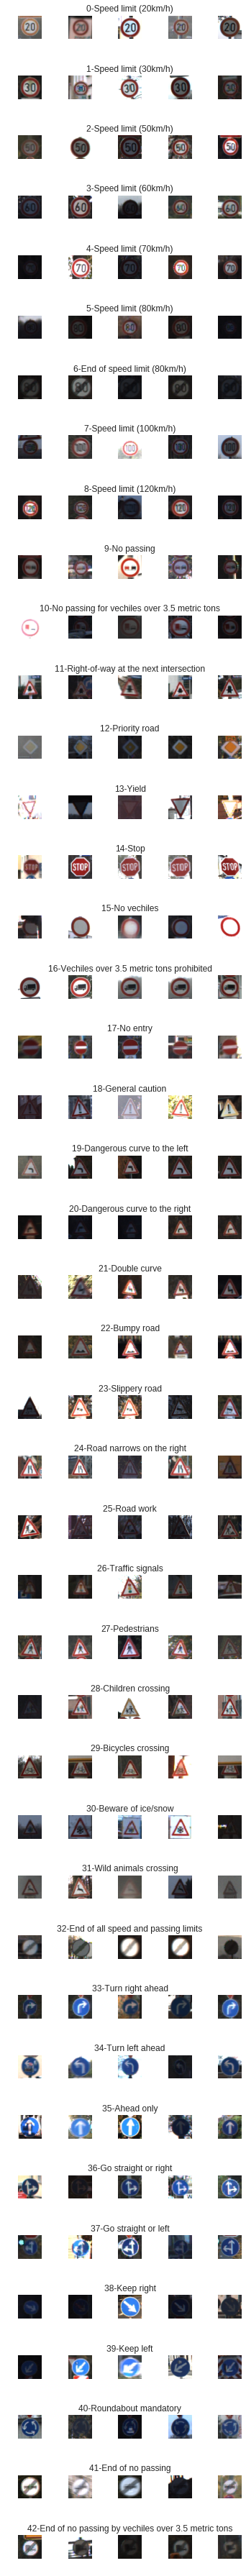

In [104]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_classes = data.shape[0]

num_of_samples = []
 
cols = 5
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)-1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) +'-'+ row['SignName'])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

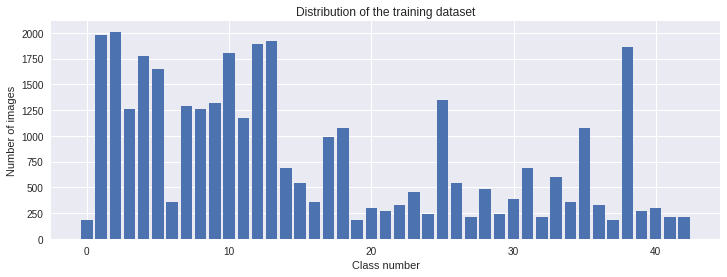

In [105]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

### PREPROCESSING

(32, 32, 3)


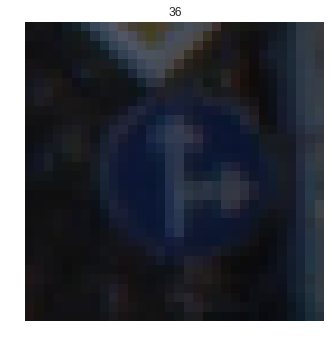

In [106]:
import cv2

plt.imshow(X_train[1000])
plt.axis('off')
plt.title(str(y_train[1000]))
print(X_train[1000].shape)

Convert to grayscale: when looking for traffic signs, color is not a very important feature, many have same color. We reduce now fro RGB to grayscale: less complex, less parameters, less computing power

(32, 32)


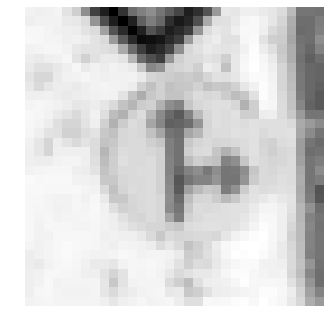

In [107]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis('off')
print(img.shape)

Histogram equalization: normalizes the historgam distribution, enhances contrast and helps to extract features

(-0.5, 31.5, 31.5, -0.5)

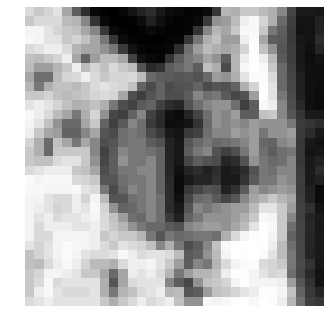

In [108]:
# Only able to work with grayscale images (or depth=1)
img = cv2.equalizeHist(img)
plt.imshow(img)
plt.axis('off')

Normalization of vales: vaues from 0 to 1

In [0]:
def preprocessing(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.equalizeHist(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

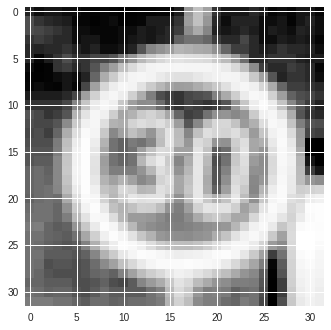

In [110]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])

Prepare data to have the correct layout

In [0]:
def reshaping(data):
  data = data.reshape(data.shape[0], data.shape[1], data.shape[2], 1)
  return data

X_train = reshaping(X_train)
X_test = reshaping(X_test)
X_val = reshaping(X_val)

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

In [0]:
# Data augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1, # 10% of the image width
                            height_shift_range=0.1, # 10% of the image height
                            zoom_range=0.2, # from 0.8 to 1.2 zooming
                            shear_range=0.1, # shear angle
                            rotation_range=10.)
# datagenerator doesnt create the images as this would be space costing, but instead creating them as requested, being more time consuming to train the model
datagen.fit(X_train)

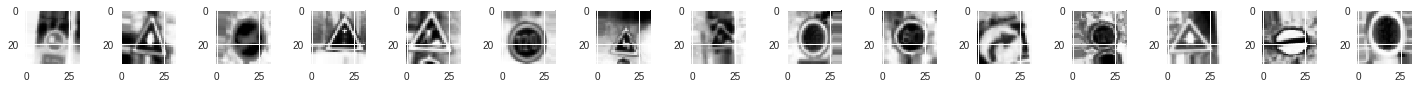

In [113]:
# Data augmentation
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))

In [114]:
X_train.shape[1:]

(32, 32, 1)

### Build  LeNet CNN

In [0]:
#define LeNet model function with dropout
# the dropout is usually between the fully connected layers, as there are more parameters to update.
def leNet_model():
    model = Sequential()
#     Not using padding in  first conv, layer due to dataset being centered, therefore the borders do not have information: 'build-in padding'
    model.add(Conv2D(60, (5,5), input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
#     0.5 -> 50% of dropout, is the value that researchers that came with dropout reccommend
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [0]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5,5), input_shape=X_train.shape[1:], activation='relu'))
#   Add conv layer
  model.add(Conv2D(60, (5,5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(30, (3,3), activation='relu'))
  #   Add conv layer
  model.add(Conv2D(30, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
#   Add dropout layer
#   model.add(Dropout(0.5)) Dropped after data augmentation
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [117]:
model = modified_model()
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 480)               0         
__________

In [0]:
# history = model.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)

In [119]:
# Data augmentation
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_val, y_val), shuffle=1)

Epoch 1/10
2000/2000 [==============================] - 51s 26ms/step - loss: 0.8773 - acc: 0.7423 - val_loss: 0.1185 - val_acc: 0.9630
Epoch 2/10
2000/2000 [==============================] - 51s 26ms/step - loss: 0.1982 - acc: 0.9388 - val_loss: 0.0618 - val_acc: 0.9796
Epoch 3/10
2000/2000 [==============================] - 50s 25ms/step - loss: 0.1308 - acc: 0.9596 - val_loss: 0.0362 - val_acc: 0.9914
Epoch 4/10
2000/2000 [==============================] - 51s 25ms/step - loss: 0.1038 - acc: 0.9674 - val_loss: 0.0188 - val_acc: 0.9950
Epoch 5/10
2000/2000 [==============================] - 52s 26ms/step - loss: 0.0904 - acc: 0.9722 - val_loss: 0.0371 - val_acc: 0.9902
Epoch 6/10
2000/2000 [==============================] - 52s 26ms/step - loss: 0.0782 - acc: 0.9761 - val_loss: 0.0277 - val_acc: 0.9932
Epoch 7/10
2000/2000 [==============================] - 51s 25ms/step - loss: 0.0687 - acc: 0.9792 - val_loss: 0.0195 - val_acc: 0.9946
Epoch 8/10
2000/2000 [==========================

Text(0.5, 0, 'epoch')

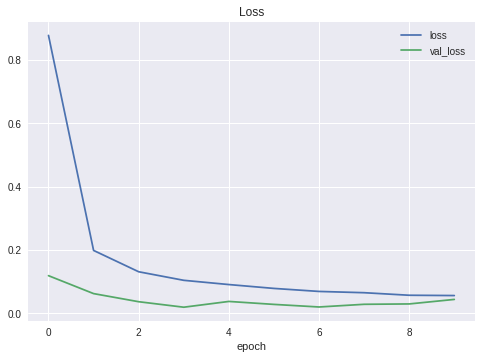

In [120]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

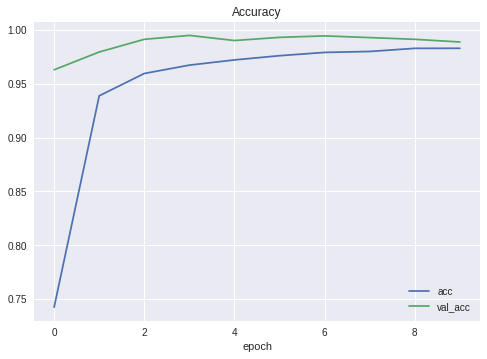

In [121]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [122]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score: ', score[0])
print('Test accuracy: ', score[1])

Test score:  0.15503742750877883
Test accuracy:  0.9688044339064464


It seems that LeNet CNN doesn't give good accuracy, and has overfitting, therefore we need to make some changes. 

First tecnique is lower the learning ratio (0.01 -> 0.001). We see an increase of the accuracy, but still same problems.

Second technique is to increease the number of kernels in the convolutional layer, to try to extract more features. boht layers increased to double. Increase accuracy, still overfitting

Third technique is to add extra convolutional layers right after the olders (same kernel nr) in LeNet (modified_model). Improvement in accuracy is visible, but overfitting is still there


Then we add extra dropout layer before Flattenning the 2nd pooling layer to try to fight overfitting. The result is a slight loss in training accuracy, but increase in validation and testing, dealing with the overfitting problem, everything over 96%

### Predicitions with modified_model

In [0]:
# Links to images
link1 = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
link2 = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
link3 = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
link4 = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
link5 = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'

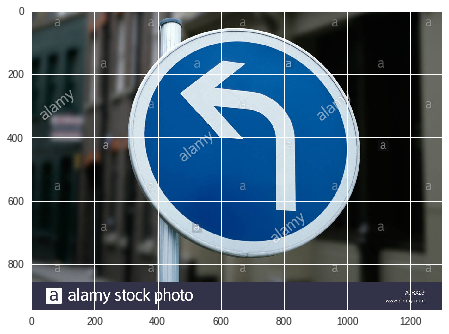

In [133]:
#fetch image
 
import requests
from PIL import Image
url = link2
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


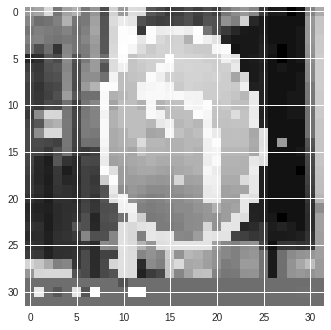

In [134]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, X_train.shape[1:3])
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)


In [135]:
#Test image
print("predicted sign: "+ str(model.predict_classes(img)) + data['SignName'][model.predict_classes(img)[0]])

predicted sign: [34]Turn left ahead


Only 2of5 images images from the link were correctly classified...

### Data augmentation

Tranform or alter training set images in some way to create more training images. Rotation, zooming.

We have a large dataset, and few images for some of the labels.

The cells that start with data augmentation comments, are added for that purpose.

After using data augmentation, the validation accuracy has increased a lot, meanwhile the testing accuracy decreased. We then erase one of the dropout layers that was included to fight the overfitting, that we now dont see.